##1. import & Data load

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
!pip install xgboost
!pip install catboost
!pip install optuna

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import bisect
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, KFold

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings(action='ignore')

In [88]:
train = pd.read_csv('/content/drive/MyDrive/HD/Data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/HD/Data/test.csv')

train, test SAMPLE_ID, ID 삭제

##2. EDA & Preprocessing

In [89]:
# 데이터 탐색
display(train.head())
display(train.info())
display(train.describe())
# 결측치 확인
display(train.isnull().sum())

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,TRAIN_000001,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,TRAIN_000002,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,TRAIN_000003,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,TRAIN_000004,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SAMPLE_ID           391939 non-null  object 
 1   ARI_CO              391939 non-null  object 
 2   ARI_PO              391939 non-null  object 
 3   SHIP_TYPE_CATEGORY  391939 non-null  object 
 4   DIST                391939 non-null  float64
 5   ATA                 391939 non-null  object 
 6   ID                  391939 non-null  object 
 7   BREADTH             391938 non-null  float64
 8   BUILT               391939 non-null  int64  
 9   DEADWEIGHT          391939 non-null  int64  
 10  DEPTH               391938 non-null  float64
 11  DRAUGHT             391938 non-null  float64
 12  GT                  391939 non-null  int64  
 13  LENGTH              391938 non-null  float64
 14  SHIPMANAGER         391939 non-null  object 
 15  FLAG                391939 non-nul

None

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,391939.000000,391938.00000,391939.000000,391939.000000,391938.000000,391938.000000,391939.000000,391938.000000,228251.000000,228251.000000,227309.000000,228251.000000,391939.000000,391939.000000,391939.000000
mean,19.328187,30.55001,14.747989,63577.506780,16.476177,11.088106,41348.968666,205.121320,-0.294910,-0.263849,18.862968,2.706992,11.841580,0.000876,61.940835
std,30.930059,10.95707,7.043988,63515.531024,6.045930,4.599298,39304.543664,75.873891,3.366585,3.736949,9.729976,1.388026,6.644114,0.000838,170.809558
min,0.000000,10.00000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-25.330000,-21.450000,-32.200000,0.000000,0.000000,0.000005,0.000000
25%,0.000000,20.00000,10.000000,14300.000000,10.000000,10.000000,10000.000000,150.000000,-2.150000,-2.280000,12.200000,1.805246,7.000000,0.000142,0.000000
50%,6.929678,30.00000,13.000000,47400.000000,20.000000,10.000000,30700.000000,190.000000,-0.130000,0.000000,21.600000,2.618063,12.000000,0.000552,7.944444
75%,25.692827,40.00000,18.000000,81500.000000,20.000000,10.000000,52100.000000,260.000000,1.540000,2.000000,26.600000,3.556236,17.000000,0.001614,49.176111
max,199.980651,60.00000,80.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.910000,29.690000,47.600000,11.179660,23.000000,0.002615,2159.130556


SAMPLE_ID                  0
ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
ATA_LT                     0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

1. 범주형 변수: ARI_CO, ARI_PO, SHIP_TYPE_CATEGORY ,SHIPMANAGER ,FLAG
2. 수치형 변수: 나머지
3. 풍향 u,v벡터, 기온, 보퍼트 풍력 계급 변수에 결측치 존재

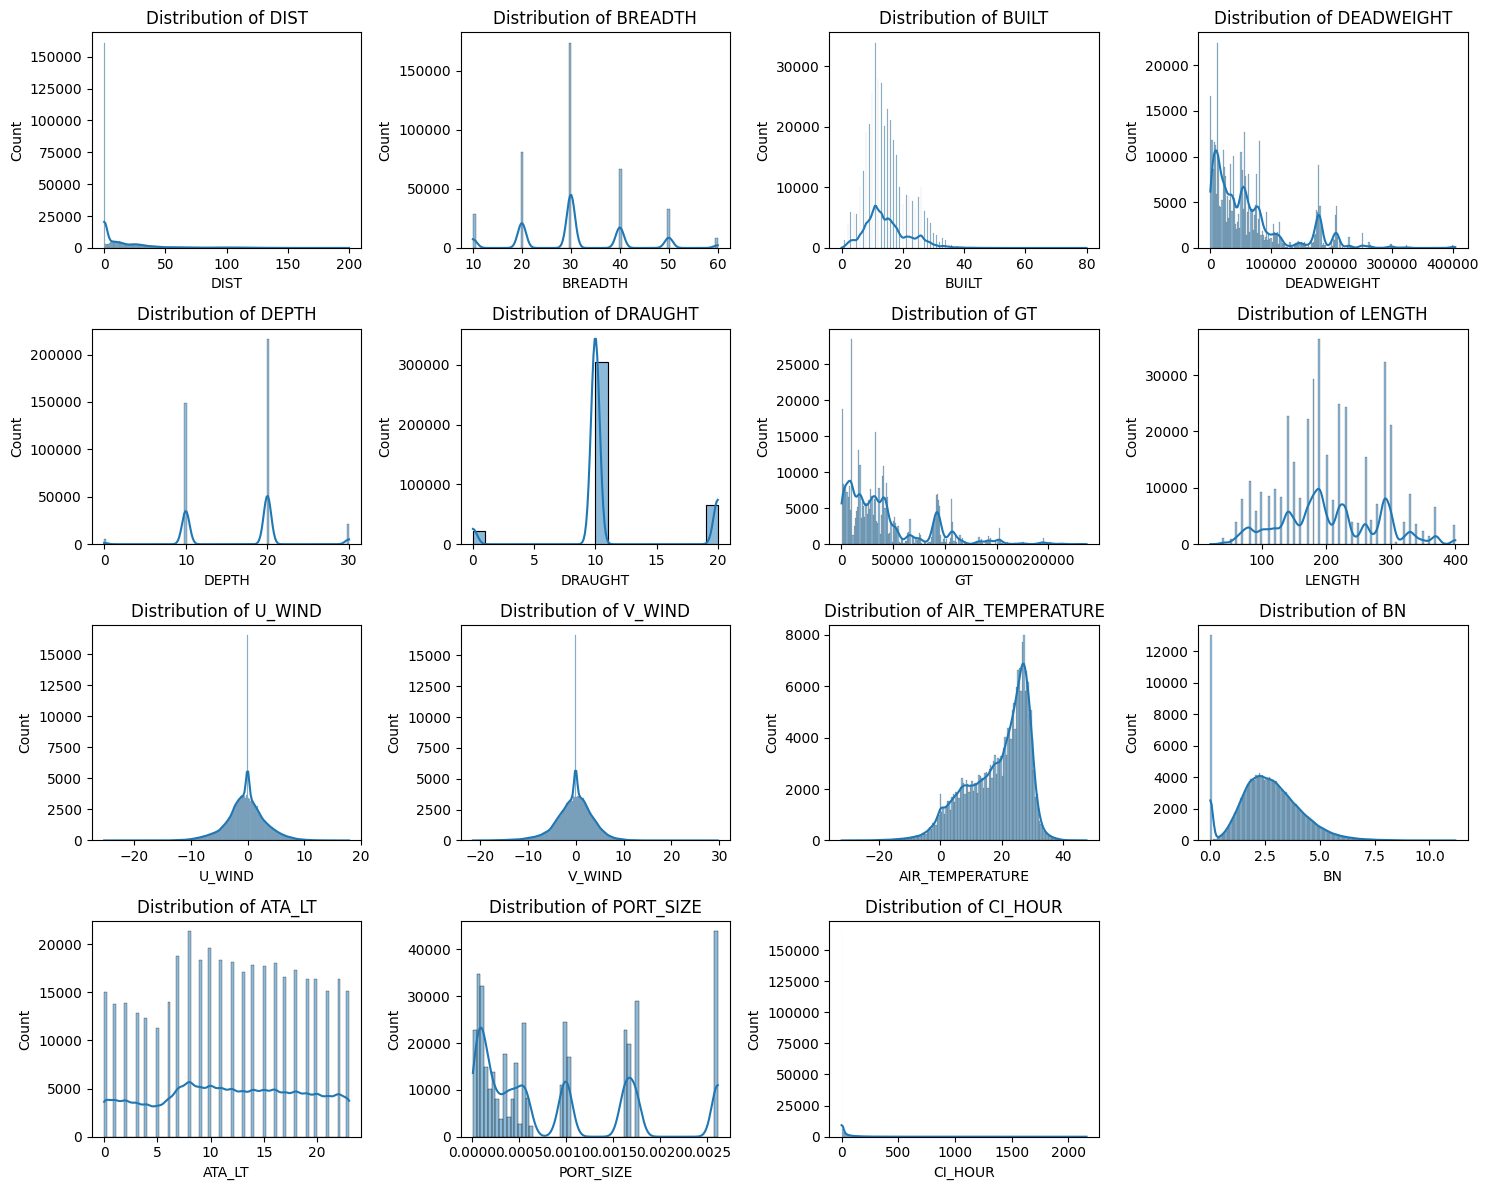

In [90]:
num_cols=['DIST', 'BREADTH', 'BUILT','DEADWEIGHT', 'DEPTH','DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN','ATA_LT', 'PORT_SIZE','CI_HOUR']

# 그래프의 크기 및 행, 열 설정
num_cols_count = len(num_cols)
num_cols_per_row = 4  # 각 행당 그래프 수를 조절
num_rows = int(math.ceil(num_cols_count / num_cols_per_row))

plt.figure(figsize=(15, 3 * num_rows))

for i, feature in enumerate(num_cols, 1):
    plt.subplot(num_rows, num_cols_per_row, i)
    sns.histplot(train[feature], kde=True)
    plt.title(f'Distribution of {feature}')

# 그래프 출력
plt.tight_layout()
plt.show()

In [91]:
# # 시각화를 통한 데이터 탐색
# plt.figure(figsize=(16, 8))
# sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap')
# plt.show()

1. DIST 변수가 제일 상관관계 높았지만 유의미한 수준이 아님
2. 선박의 크기및 용적량 변수들 끼리의 상관계수 높게 측정

* breadth, deadweight, depth, draught, gt, length - [폭, 재화중량톤수, 깊이, 흘수높이, 용적톤수, 길이]

In [92]:
# DIST가 0이면 CI_HOUR도 0이어야함 - 개념적으로
DIST_0 = train[train['DIST'] == 0]
CI_HOUR_NOT_0_idx = DIST_0.index[DIST_0['CI_HOUR'] != 0].tolist()
print(CI_HOUR_NOT_0_idx)
train.loc[CI_HOUR_NOT_0_idx, ['CI_HOUR']] = 0
train

[2521, 6439, 24059, 26501, 36741, 39476, 59076, 66864, 69524, 73609, 77864, 111963, 114363, 130517, 146884, 196830, 212002, 215246, 237240, 237396, 270856, 297812, 306130, 314316, 350939, 357643, 378544, 389245]


,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,TRAIN_000001,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,TRAIN_000002,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,TRAIN_000003,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,TRAIN_000004,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,TRAIN_391934,JP,QYY1,Container,0.000000,2017-06-06 5:02,Y375615,20.0,27,6820,...,110.0,KEJZ24,"China, People's Republic Of",NaN,NaN,NaN,NaN,14,0.000552,0.000000
391935,TRAIN_391935,SG,GIW5,Bulk,5.884603,2019-10-16 0:36,K635567,10.0,12,3160,...,80.0,JLTM64,Vietnam,-0.66,0.97,27.3,1.253491,8,0.002615,144.061389
391936,TRAIN_391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35,J284147,30.0,8,60300,...,200.0,YERJ68,Singapore,-3.44,7.99,21.1,4.766257,18,0.000155,41.482222
391937,TRAIN_391937,TW,JWI3,Container,9.448179,2015-01-08 7:15,J644215,30.0,29,23800,...,170.0,HCZK58,Comoros,NaN,NaN,NaN,NaN,15,0.000990,7.485278


In [93]:
# BUILT, ATA_LT 컬럼 제거
train.drop(columns=['BUILT', 'ATA_LT'], inplace=True)
test.drop(columns=['BUILT', 'ATA_LT'], inplace=True)

# SAMPLE_ID, ID 컬럼 제거
train = train.drop(['SAMPLE_ID', 'ID'], axis=1)
test = test.drop(['SAMPLE_ID', 'ID'], axis=1)
train.head(5)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,BREADTH,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,30.0,24300,10.0,10.0,16700,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,30.0,35900,10.0,10.0,23500,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,50.0,146000,30.0,20.0,140000,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,20.0,6910,10.0,10.0,5400,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,50.0,116000,20.0,10.0,96600,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,0.002615,253.554444


1. 유의미한 선형적 관계를 볼 수는 없다.
2. BUILT, ATA_LT 컬럼 제거(종속변수와의 선형관계 0)

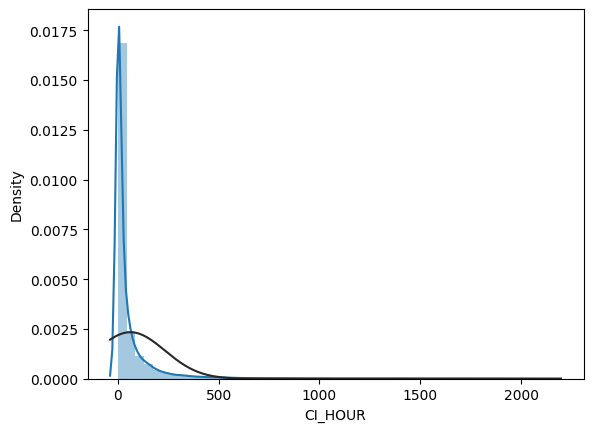

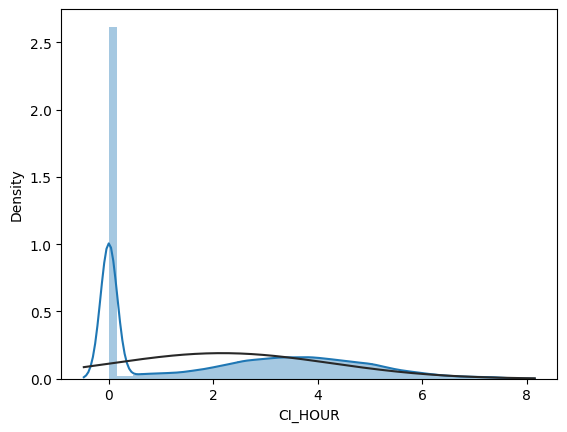

<Figure size 640x480 with 0 Axes>

In [94]:
# 종속변수 Log 변환
sns.distplot(train['CI_HOUR'], fit=norm);
fig = plt.figure()

train.CI_HOUR = np.log1p(train.CI_HOUR)

sns.distplot(train['CI_HOUR'], fit=norm);
fig = plt.figure()

In [95]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

#도착 국가와 항구 합치기
train['ARI_COPO'] = train['ARI_CO'] + '_' + train['ARI_PO']
test['ARI_COPO'] = test['ARI_CO'] + '_' + test['ARI_PO']

# ARI_CO, ARI_PO 컬럼 제거
train.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)
test.drop(columns=['ARI_CO', 'ARI_PO'], inplace=True)

In [96]:
train.columns

Index(['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'PORT_SIZE', 'CI_HOUR', 'year', 'month', 'day',
       'hour', 'minute', 'weekday', 'ARI_COPO'],
      dtype='object')

In [97]:
# Categorical 컬럼 인코딩
categorical_features = ['ARI_COPO', 'SHIP_TYPE_CATEGORY', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


In [98]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, QuantileTransformer

def quantileTransform(data) :
    qt = QuantileTransformer()
    scaled_data = pd.DataFrame(qt.fit_transform(data), columns=data.columns)
    return scaled_data

def logTransform(data) :
    scaled_cols = data.columns
    scaled_data = data.apply(lambda x: np.log1p(x))
    return scaled_data

left_skewed_cols = ['DEADWEIGHT', 'GT', 'DIST', 'BN']
right_skewed_cols = ['AIR_TEMPERATURE']

# train_scaler
train[left_skewed_cols] = logTransform(train[left_skewed_cols])
train[right_skewed_cols] = quantileTransform(train[right_skewed_cols])
# test_scaler
test[left_skewed_cols] = logTransform(test[left_skewed_cols])
test[right_skewed_cols] = quantileTransform(test[right_skewed_cols])



# 그 외 수치
#minmax? standard?
from sklearn.preprocessing import RobustScaler

s_columns = ['BREADTH', 'DEPTH', 'DRAUGHT',  'LENGTH', 'U_WIND', 'V_WIND', 'PORT_SIZE']
standardScaler = MinMaxScaler()

train[s_columns] = standardScaler.fit_transform(train[s_columns])
test[s_columns] = standardScaler.transform(test[s_columns])
train

# #수치형 데이터를 표준화
# num_features=['DIST', 'BREADTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH', 'U_WIND', 'V_WIND','AIR_TEMPERATURE', 'BN', 'PORT_SIZE']

# scaler = StandardScaler()
# train[num_features] = scaler.fit_transform(train[num_features])
# test[num_features] = scaler.transform(test[num_features])

,SHIP_TYPE_CATEGORY,DIST,BREADTH,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,...,BN,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday,ARI_COPO
0,2,3.462011,0.4,10.098273,0.333333,0.5,9.723224,0.421053,686,89,...,1.310221,1.000000,1.492904,2018,12,17,21,29,0,90
1,0,0.000000,0.4,10.488520,0.333333,0.5,10.064798,0.421053,4720,74,...,1.310221,0.081242,0.000000,2014,9,23,6,59,1,52
2,2,0.000000,0.8,11.891369,1.000000,1.0,11.849405,0.921053,1370,73,...,1.310221,0.616515,0.000000,2015,2,3,22,0,1,23
3,2,0.000000,0.2,8.840870,0.333333,0.5,8.594339,0.263158,3809,5,...,1.289053,0.134672,0.000000,2020,1,17,4,2,4,66
4,2,3.333548,0.8,11.661354,0.666667,0.5,11.478344,0.736842,1687,67,...,1.251606,1.000000,5.539515,2020,1,26,7,51,6,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,2,0.000000,0.2,8.827761,0.333333,0.5,8.480737,0.236842,2562,20,...,1.310221,0.209594,0.000000,2017,6,6,5,2,1,61
391935,0,1.929287,0.0,8.058644,0.333333,0.5,7.378384,0.157895,2400,124,...,0.812481,1.000000,4.977157,2019,10,16,0,36,2,90
391936,0,4.271936,0.4,11.007104,0.666667,0.5,10.457401,0.473684,6106,102,...,1.752023,0.057661,3.749086,2021,3,23,22,35,1,97
391937,2,2.346428,0.4,10.077483,0.333333,0.5,9.735128,0.394737,1771,22,...,1.310221,0.377319,2.138333,2015,1,8,7,15,3,93


In [99]:
train.head(5)

,SHIP_TYPE_CATEGORY,DIST,BREADTH,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,...,BN,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday,ARI_COPO
0,2,3.462011,0.4,10.098273,0.333333,0.5,9.723224,0.421053,686,89,...,1.310221,1.000000,1.492904,2018,12,17,21,29,0,90
1,0,0.000000,0.4,10.488520,0.333333,0.5,10.064798,0.421053,4720,74,...,1.310221,0.081242,0.000000,2014,9,23,6,59,1,52
2,2,0.000000,0.8,11.891369,1.000000,1.0,11.849405,0.921053,1370,73,...,1.310221,0.616515,0.000000,2015,2,3,22,0,1,23
3,2,0.000000,0.2,8.840870,0.333333,0.5,8.594339,0.263158,3809,5,...,1.289053,0.134672,0.000000,2020,1,17,4,2,4,66
4,2,3.333548,0.8,11.661354,0.666667,0.5,11.478344,0.736842,1687,67,...,1.251606,1.000000,5.539515,2020,1,26,7,51,6,90


1. 범주형 및 datetime 컬럼 처리
2. 수치데이터 표준화

### LGBM feature selection

Model Tune for lgbm.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 22
[LightGBM] [Info] Start training from score 2.163121


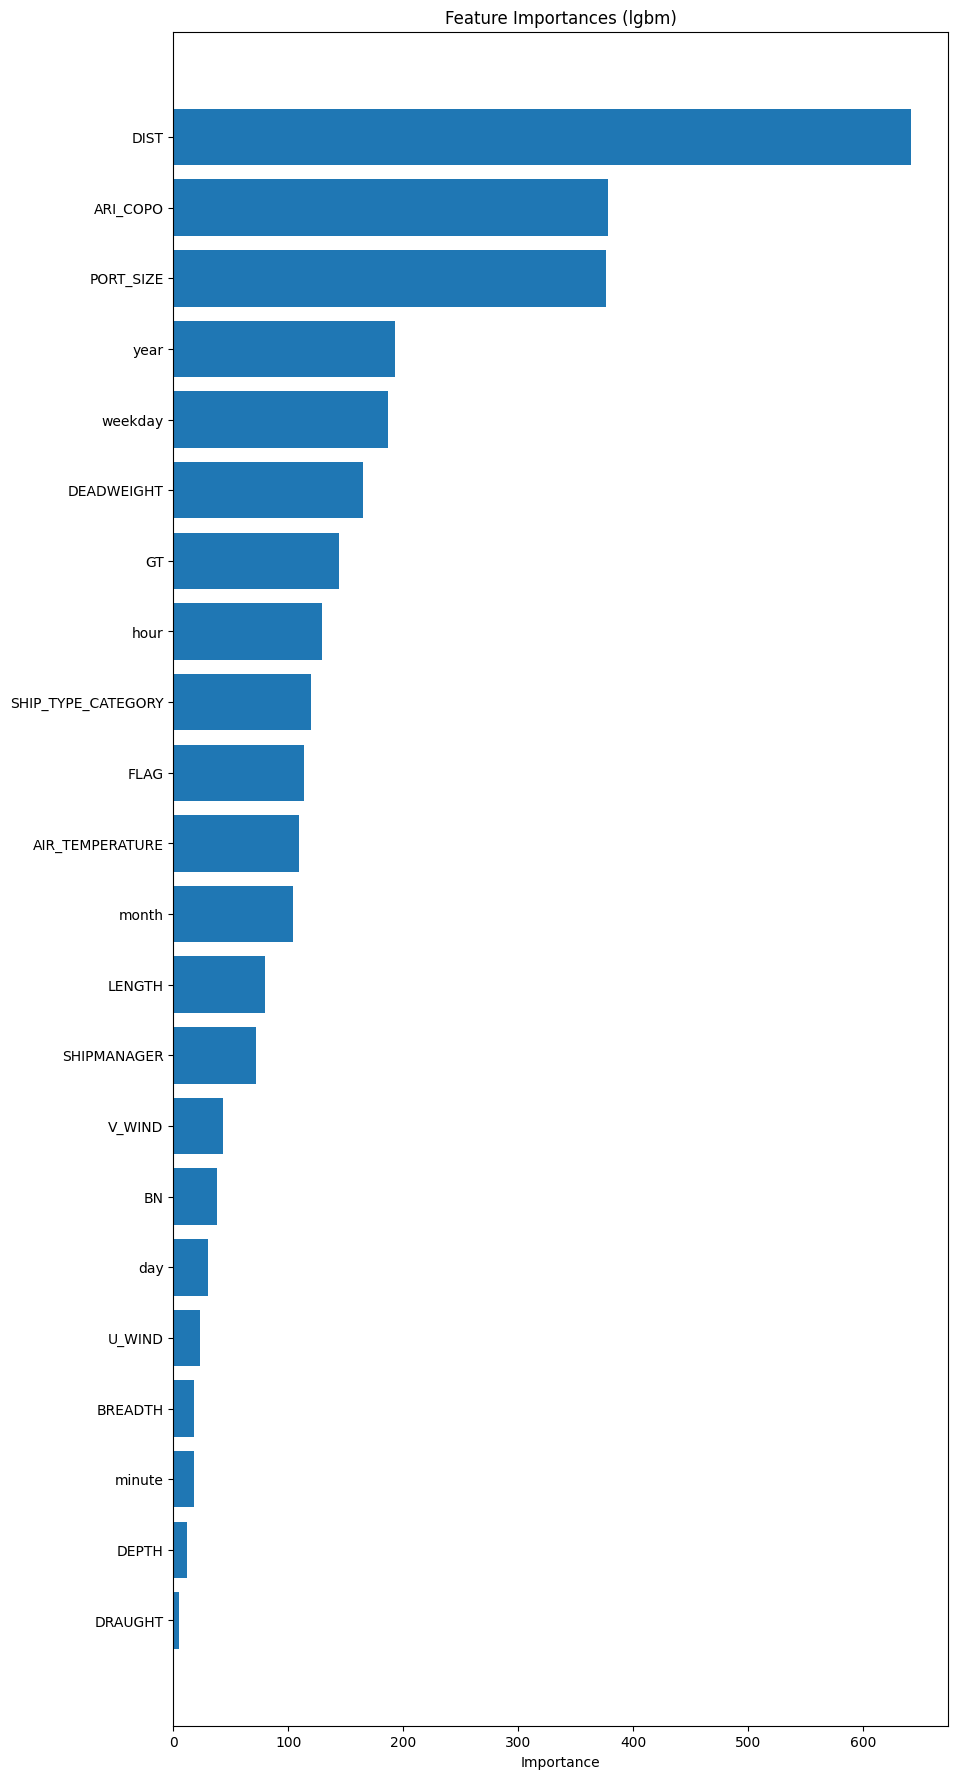

In [100]:
def train_and_evaluate(model, model_name, train_x, train_y):
    print(f'Model Tune for {model_name}.')
    model.fit(train_x, train_y)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(train_x.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(train_x.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(train_x.shape[1]), train_x.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

train_x = train.drop(columns=['CI_HOUR'])
train_y = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(LGBMRegressor(), 'lgbm', train_x, train_y)

In [101]:
lgbm_feature_importances

array([120, 642,  18, 165,  12,   5, 144,  80,  72, 114,  23,  43, 109,
        38, 376, 193, 104,  30, 129,  18, 187, 378], dtype=int32)

In [102]:
train_x.columns

Index(['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'PORT_SIZE', 'year', 'month', 'day', 'hour',
       'minute', 'weekday', 'ARI_COPO'],
      dtype='object')

#### PCA 추가

In [103]:
### 150 이하의 threshold 있는 것이 더 결과가 좋지 않음
threshold = 110 ## shiptype 아래 중요도 다 삭제 , 점수 : 46.9236446775
## GT 아래 중요도 다 삭제, 점수 : 44.5665247547
# threshold = 120 ## hour 아래 중요도 다 삭제 , 점수 : 44.515610949
low_importance_features = train_x.columns[lgbm_feature_importances < threshold]

In [104]:
low_importance_features

Index(['BREADTH', 'DEPTH', 'DRAUGHT', 'LENGTH', 'SHIPMANAGER', 'U_WIND',
       'V_WIND', 'AIR_TEMPERATURE', 'BN', 'month', 'day', 'minute'],
      dtype='object')

In [105]:
import pandas as pd

# 가상의 특성 중요도 데이터프레임 생성
feature_importance = pd.DataFrame({
    'name_list': ['SHIP_TYPE_CATEGORY', 'DIST', 'BREADTH', 'DEADWEIGHT', 'DEPTH',
       'DRAUGHT', 'GT', 'LENGTH', 'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND',
       'AIR_TEMPERATURE', 'BN', 'PORT_SIZE', 'year', 'month', 'day', 'hour',
       'minute', 'weekday', 'ARI_COPO'],
    'Importance': [117, 652, 11, 178, 7, 2, 159, 77, 98, 95, 21, 27, 113,
        36, 363, 197, 103, 27, 125, 22, 197, 373]
})

# 원하는 그룹 수 설정
num_groups = 4

# 중요도 값에 따라 특성 정렬
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# 그룹별로 특성을 나누기 위한 그룹 크기 계산
group_size = len(feature_importance) // num_groups

# 그룹별로 특성 나누기
feature_groups = []
for i in range(num_groups):
    start_idx = i * group_size
    end_idx = start_idx + group_size
    group = feature_importance.iloc[start_idx:end_idx]['name_list'].tolist()  # 'name_list'로 수정
    feature_groups.append(group)

# 원하는 그룹을 정의
# group_definitions = [['DIST', 'PORT_SIZE', 'ARI_COPO'], ['weekday_cos', 'year_cos']]
# feature_groups = []
# for group_definition in group_definitions:
#     group = feature_importance[feature_importance['name_list'].isin(group_definition)]['name_list'].tolist()
#     feature_groups.append(group)

# 결과 출력
for i, group in enumerate(feature_groups):
    print(f'Group {i + 1}: {group}')


Group 1: ['DIST', 'ARI_COPO', 'PORT_SIZE', 'weekday', 'year']
Group 2: ['DEADWEIGHT', 'GT', 'hour', 'SHIP_TYPE_CATEGORY', 'AIR_TEMPERATURE']
Group 3: ['month', 'SHIPMANAGER', 'FLAG', 'LENGTH', 'BN']
Group 4: ['day', 'V_WIND', 'minute', 'U_WIND', 'BREADTH']


In [106]:
feature_groups

[['DIST', 'ARI_COPO', 'PORT_SIZE', 'weekday', 'year'],
 ['DEADWEIGHT', 'GT', 'hour', 'SHIP_TYPE_CATEGORY', 'AIR_TEMPERATURE'],
 ['month', 'SHIPMANAGER', 'FLAG', 'LENGTH', 'BN'],
 ['day', 'V_WIND', 'minute', 'U_WIND', 'BREADTH']]

In [107]:
from sklearn.decomposition import PCA
import pandas as pd

# groups = [feature_groups[0], feature_groups[1], feature_groups[2], feature_groups[3]]
featuregroups = [['DIST', 'ARI_COPO'],['PORT_SIZE', 'ARI_COPO'],['DIST', 'ARI_COPO', 'PORT_SIZE', 'weekday', 'year']]
groups = [feature_groups[0], feature_groups[1], feature_groups[2]]

pca_data1 = []
pca_test1 = []
pca_columns = ['PCA_Group0','PCA_Group1','PCA_Group2']
for i,group in enumerate(groups):
    # 데이터 선택
    selected_data_X = train_x[group]

    # PCA
    pca = PCA(n_components=1)
    selected_data_X_pca = pca.fit_transform(selected_data_X)

    # PCA 적용 후 데이터를 데이터프레임에 추가
    pca_data1.append(pd.DataFrame(selected_data_X_pca, columns=[pca_columns[i]]))

    selected_test_X = test[group]

    # PCA
    pca = PCA(n_components=1)
    selected_test_X_pca = pca.fit_transform(selected_test_X)

    # PCA 적용 후 데이터를 데이터프레임에 추가
    pca_test1.append(pd.DataFrame(selected_test_X_pca, columns=[pca_columns[i]]))

# 각 그룹의 PCA 결과 데이터를 수평으로 연결하여 하나의 변수로 합침
merged_data_df = pd.concat(pca_data1, axis=1)
merged_test_df = pd.concat(pca_test1, axis=1)

# Result 확인
merged_data_df

,PCA_Group0,PCA_Group1,PCA_Group2
0,40.424763,10.033658,2626.249338
1,2.435210,-4.968809,-1407.752794
2,-26.552643,11.022653,1942.247065
3,16.470290,-6.959251,-496.762845
4,40.423070,-3.975812,1625.246198
...,...,...,...
391934,11.457404,-5.959185,750.239304
391935,40.444849,-10.954756,912.254492
391936,47.431626,11.028326,-2793.748646
391937,43.404335,-3.966206,1541.239619


In [108]:
scal_train_x = train_x.drop(columns=low_importance_features)
scal_test = test.drop(columns=low_importance_features)

In [109]:
drop_col = ['FLAG','SHIP_TYPE_CATEGORY']
scal_train_x = scal_train_x.drop(columns=drop_col)
scal_test = scal_test.drop(columns=drop_col)

In [110]:
scal_train_x

,DIST,DEADWEIGHT,GT,PORT_SIZE,year,hour,weekday,ARI_COPO
0,3.462011,10.098273,9.723224,1.000000,2018,21,0,90
1,0.000000,10.488520,10.064798,0.081242,2014,6,1,52
2,0.000000,11.891369,11.849405,0.616515,2015,22,1,23
3,0.000000,8.840870,8.594339,0.134672,2020,4,4,66
4,3.333548,11.661354,11.478344,1.000000,2020,7,6,90
...,...,...,...,...,...,...,...,...
391934,0.000000,8.827761,8.480737,0.209594,2017,5,1,61
391935,1.929287,8.058644,7.378384,1.000000,2019,0,2,90
391936,4.271936,11.007104,10.457401,0.057661,2021,22,1,97
391937,2.346428,10.077483,9.735128,0.377319,2015,7,3,93


#### GPU

In [111]:
!nvidia-smi

Sun Oct 29 16:26:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |    815MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [112]:
!pip install tensorflow

In [113]:
import tensorflow as tf
device_name=tf.test.gpu_device_name()
if device_name!='/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [114]:
import tensorflow as tf

# GPU 상태 확인
tf.config.experimental.get_memory_info('GPU:0')


{'current': 1625600, 'peak': 63129344}

### 모델 앙상블

In [115]:
X_train_f = pd.concat([scal_train_x, merged_data_df], axis=1)
X_test_f = pd.concat([scal_test, merged_test_df], axis=1)
# X_train_f = scal_train_x
# X_test_f = scal_test

Model Tune for lgbm.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 11
[LightGBM] [Info] Start training from score 2.163121


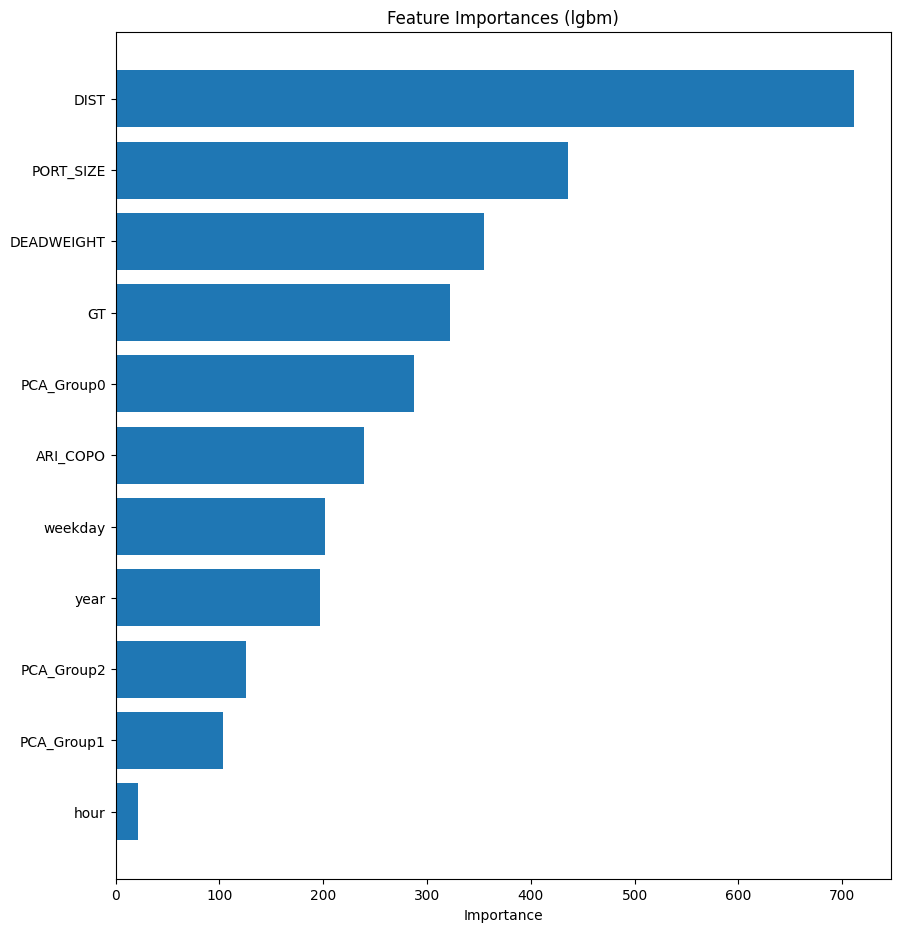

In [116]:
# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(LGBMRegressor(), 'lgbm', X_train_f, train_y)

In [117]:
# X_train_f = X_train_f.drop(columns='PCA_Group0')
# X_test_f = X_test_f.drop(columns='PCA_Group0')

In [118]:
X_train_f

,DIST,DEADWEIGHT,GT,PORT_SIZE,year,hour,weekday,ARI_COPO,PCA_Group0,PCA_Group1,PCA_Group2
0,3.462011,10.098273,9.723224,1.000000,2018,21,0,90,40.424763,10.033658,2626.249338
1,0.000000,10.488520,10.064798,0.081242,2014,6,1,52,2.435210,-4.968809,-1407.752794
2,0.000000,11.891369,11.849405,0.616515,2015,22,1,23,-26.552643,11.022653,1942.247065
3,0.000000,8.840870,8.594339,0.134672,2020,4,4,66,16.470290,-6.959251,-496.762845
4,3.333548,11.661354,11.478344,1.000000,2020,7,6,90,40.423070,-3.975812,1625.246198
...,...,...,...,...,...,...,...,...,...,...,...
391934,0.000000,8.827761,8.480737,0.209594,2017,5,1,61,11.457404,-5.959185,750.239304
391935,1.929287,8.058644,7.378384,1.000000,2019,0,2,90,40.444849,-10.954756,912.254492
391936,4.271936,11.007104,10.457401,0.057661,2021,22,1,97,47.431626,11.028326,-2793.748646
391937,2.346428,10.077483,9.735128,0.377319,2015,7,3,93,43.404335,-3.966206,1541.239619


In [119]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

In [120]:
# # 각 회귀 모델 생성
# best_xgb_params={'lambda': 11.301844432706362, 'alpha': 0.510704000002835, 'colsample_bytree': 0.9126912634499058, 'subsample': 0.9494229824513081,
#                 'learning_rate': 0.02384727905665833, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 0, 'gamma': 0.0040832097981139785, 'scale_pos_weight': 2.0645359355109343,
#                 'max_delta_step': 8.596331811005982, 'tree_method': 'gpu_hist', 'n_estimators': 20000, 'objective': 'reg:squarederror'}
# best_catboost_params={'l2_leaf_reg': 0.0018716016058186564, 'max_bin': 312, 'subsample': 0.8854187625592285, 'learning_rate': 0.016922143716620028,
#                     'n_estimators': 1499, 'max_depth': 15, 'random_state': 2020, 'min_data_in_leaf': 41, 'loss_function': 'MAE',
#                     'task_type': 'GPU', 'bootstrap_type': 'Bernoulli'}
# best_lgbm_params={'random_state': 2020, 'n_estimators': 1304, 'reg_alpha': 2.707394216256663, 'reg_lambda': 0.038023491291765396, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 17, 'num_leaves': 682, 'min_child_samples': 29, 'cat_smooth': 62, 'objective': 'mae'}

# # xgb_model = XGBRegressor(best_xgb_params)
# # lgbm_model = LGBMRegressor(best_lgbm_params)
# # catboost_model = CatBoostRegressor(best_catboost_params)
# # gb_model = GradientBoostingRegressor(random_state=42)
# # rf_model = RandomForestRegressor(random_state=42)
# # svr_model = SVR()

# # VotingRegressor 생성
# # voting_regressor = VotingRegressor(estimators=[
# #     ('gb', gb_model),
# #     ('xgb', xgb_model),
# #     ('lgbm', lgbm_model),
# #     ('catboost', catboost_model),
# #     ('rf', rf_model),
# #     ('svr', svr_model)
# # ], weights=[1, 2, 3, 2, 1, 1])

# # XGBoost 모델
# xgb_model = XGBRegressor(
#     objective='reg:squarederror',  # 목적 함수 설정
#     n_estimators=best_xgb_params['n_estimators'],
#     max_depth=best_xgb_params['max_depth'],
#     learning_rate=best_xgb_params['learning_rate'],
#     min_child_weight=best_xgb_params['min_child_weight'],
#     gamma=best_xgb_params['gamma'],
#     subsample=best_xgb_params['subsample'],
#     colsample_bytree=best_xgb_params['colsample_bytree'],
#     alpha=best_xgb_params['alpha'],
#     reg_lambda=best_xgb_params['lambda'],
#     scale_pos_weight=best_xgb_params['scale_pos_weight'],
#     max_delta_step=best_xgb_params['max_delta_step'],
#     # tree_method=best_xgb_params['tree_method'],
#     random_state=best_xgb_params['random_state']
#     # 나머지 하이퍼파라미터 추가
# )

# # LightGBM 모델
# lgbm_model = LGBMRegressor(
#     objective='mae',  # 목적 함수 설정
#     n_estimators=best_lgbm_params['n_estimators'],
#     max_depth=best_lgbm_params['max_depth'],
#     learning_rate=best_lgbm_params['learning_rate'],
#     num_leaves=best_lgbm_params['num_leaves'],
#     min_child_samples=best_lgbm_params['min_child_samples'],
#     subsample=best_lgbm_params['subsample'],
#     colsample_bytree=best_lgbm_params['colsample_bytree'],
#     reg_alpha=best_lgbm_params['reg_alpha'],
#     reg_lambda=best_lgbm_params['reg_lambda'],
#     cat_smooth=best_lgbm_params['cat_smooth'],
#     random_state=best_lgbm_params['random_state']
#     # 나머지 하이퍼파라미터 추가
# )

# # CatBoost 모델
# catboost_model = CatBoostRegressor(
#     loss_function='MAE',  # 손실 함수 설정
#     n_estimators=best_catboost_params['n_estimators'],
#     max_depth=best_catboost_params['max_depth'],
#     learning_rate=best_catboost_params['learning_rate'],
#     min_data_in_leaf=best_catboost_params['min_data_in_leaf'],
#     l2_leaf_reg=best_catboost_params['l2_leaf_reg'],
#     max_bin=best_catboost_params['max_bin'],
#     subsample=best_catboost_params['subsample'],
#     bootstrap_type=best_catboost_params['bootstrap_type'],
#     # task_type=best_catboost_params['task_type'],
#     random_state=best_catboost_params['random_state']
#     # 나머지 하이퍼파라미터 추가
# )


In [121]:
# voting_regressor = VotingRegressor(estimators=[
#     ('xgb', xgb_model),
#     ('lgbm', lgbm_model),
#     ('catboost', catboost_model)
# ], weights=[1, 1, 1])

# # VotingRegressor 학습
# voting_regressor.fit(X_train_f, train_y)

In [122]:
# # VotingRegressor로 예측
# voting_pred = voting_regressor.predict(X_test_f)

In [123]:
# # 로그변환 해제
# ensemble_predictions = []
# voting_pred = np.where(voting_pred < 0, 0, voting_pred)
# ensemble_predictions.append(np.expm1(voting_pred))
# final_predictions = np.mean(ensemble_predictions, axis=0)

In [124]:
# # MAE 계산
# voting_mae = mean_absolute_error(train_y, voting_pred)
# print(f"VotingRegressor MAE: {voting_mae}")

In [125]:
# lgbm_model = LGBMRegressor(
#     objective='mae',  # 목적 함수 설정
#     n_estimators=best_lgbm_params['n_estimators'],
#     max_depth=best_lgbm_params['max_depth'],
#     learning_rate=best_lgbm_params['learning_rate'],
#     num_leaves=best_lgbm_params['num_leaves'],
#     min_child_samples=best_lgbm_params['min_child_samples'],
#     subsample=best_lgbm_params['subsample'],
#     colsample_bytree=best_lgbm_params['colsample_bytree'],
#     reg_alpha=best_lgbm_params['reg_alpha'],
#     reg_lambda=best_lgbm_params['reg_lambda'],
#     cat_smooth=best_lgbm_params['cat_smooth'],
#     random_state=best_lgbm_params['random_state']
#     # 나머지 하이퍼파라미터 추가
# )

# # 5-Fold 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
# ensemble_predictions = []
# scores = []

# for train_idx, val_idx in kf.split(X_train_f):
#     X_t, X_val = X_train_f.iloc[train_idx], X_train_f.iloc[val_idx]
#     y_t, y_val = train_y[train_idx], train_y[val_idx]

#     # 두 모델 모두 학습
#     lgbm_model.fit(X_t, y_t)

#     # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
#     val_pred = lgbm_model.predict(X_val)

#     # Validation set에 대한 대회 평가 산식 계산 후 저장
#     scores.append(mean_absolute_error(np.expm1(y_val), np.expm1(val_pred)))

#     # test 데이터셋에 대한 예측 수행 후 저장
#     lgbm_pred = lgbm_model.predict(X_test_f)
#     lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
#     ensemble_predictions.append(np.expm1(lgbm_pred))

# # K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
# final_predictions = np.mean(ensemble_predictions, axis=0)

# # 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
# print("Validation : MAE scores for each fold:", scores)
# print("Validation : MAE:", np.mean(scores))

In [126]:
# # XGBoost 모델
# xgb_model = XGBRegressor(
#     objective='reg:squarederror',  # 목적 함수 설정
#     n_estimators=best_xgb_params['n_estimators'],
#     max_depth=best_xgb_params['max_depth'],
#     learning_rate=best_xgb_params['learning_rate'],
#     min_child_weight=best_xgb_params['min_child_weight'],
#     gamma=best_xgb_params['gamma'],
#     subsample=best_xgb_params['subsample'],
#     colsample_bytree=best_xgb_params['colsample_bytree'],
#     alpha=best_xgb_params['alpha'],
#     reg_lambda=best_xgb_params['lambda'],
#     scale_pos_weight=best_xgb_params['scale_pos_weight'],
#     max_delta_step=best_xgb_params['max_delta_step'],
#     # tree_method=best_xgb_params['tree_method'],
#     random_state=best_xgb_params['random_state']
#     # 나머지 하이퍼파라미터 추가
# )

# # 5-Fold 설정
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
# ensemble_predictions = []
# scores = []

# for train_idx, val_idx in kf.split(X_train_f):
#     X_t, X_val = X_train_f.iloc[train_idx], X_train_f.iloc[val_idx]
#     y_t, y_val = train_y[train_idx], train_y[val_idx]

#     # 두 모델 모두 학습
#     xgb_model.fit(X_t, y_t)

#     # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
#     val_pred = xgb_model.predict(X_val)

#     # Validation set에 대한 대회 평가 산식 계산 후 저장
#     scores.append(mean_absolute_error(np.expm1(y_val), np.expm1(val_pred)))

#     # test 데이터셋에 대한 예측 수행 후 저장
#     xgb_pred = xgb_model.predict(X_test_f)
#     xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)
#     ensemble_predictions.append(np.expm1(xgb_pred))

# # K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
# final_predictions = np.mean(ensemble_predictions, axis=0)

# # 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
# print("Validation : MAE scores for each fold:", scores)
# print("Validation : MAE:", np.mean(scores))

### GRU 구현

In [127]:
# import torch
# import torch.nn
# import torchvision.transforms as transforms
# import torchvision.datasets
# from torch.autograd import Variable
# from torch.nn import Parameter
# import torch.nn as nn
# from torch import Tensor
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# import math

# import matplotlib.pyplot as plt
# from datetime import datetime
# import seaborn as sns

# class GRU(nn.Module) :
#     def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
#         super(GRU, self).__init__()
#         self.num_classes = num_classes
#         self.num_layers = num_layers
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.seq_length = seq_length

#         self.gru = nn.GRU(input_size=input_size,hidden_size=hidden_size,
#                          num_layers=num_layers,batch_first=True)
#         self.fc_1 = nn.Linear(hidden_size, 128)
#         self.fc = nn.Linear(128, num_classes)
#         self.relu = nn.ReLU()

#     def forward(self, x) :
#         h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
#         output, (hn) = self.gru(x, (h_0))
#         hn = hn.view(-1, self.hidden_size)
#         out = self.relu(hn)
#         out = self.fc_1(out)
#         out = self.relu(out)
#         out = self.fc(out)
#         return out

In [128]:
# num_epochs = 1000
# learning_rate = 0.0001

# input_size=4
# hidden_size=2
# num_layers=1

# num_classes=1
# model=GRU(num_classes,input_size,hidden_size,num_layers,X_train_f.shape[1])

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
X_train = []
Y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    Y_train.append(training_set_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test = []
Y_test = []
for i in range(60, test_set_scaled.shape[0]):
    X_test.append(test_set_scaled[i-60:i, 0])
    Y_test.append(test_set_scaled[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [129]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 가상의 데이터 생성
X = np.random.randn(100, 10, 20)  # 100개의 시퀀스, 각 시퀀스는 10개의 시간 단계와 20개의 특성을 가집니다.
y = np.random.randint(2, size=(100, 1))  # 이진 분류를 위한 가상의 레이블 (0 또는 1)

# 데이터를 학습 및 테스트 세트로 분할
train_X, val_X, train_y, val_y = train_test_split(X_train_f, train_y, test_size=0.3, random_state=42, shuffle=True)

# 모델 생성
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(10, 20)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [131]:
# 모델 학습
from keras.models import save_model, load_model

# K-Fold 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)

# K-Fold 교차 검증 및 모델 학습
for train_index, test_index in kf.split(X):
    train_X, val_X = X[train_index], X[test_index]
    train_y, val_y = y[train_index], y[test_index]

    # 모델 생성
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=(10, 20)))  # 입력 형태를 (10, 20)으로 변경
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 모델 학습
    history = model.fit(
        train_X,
        train_y,
        validation_data=(val_X, val_y),
        epochs=100,
        batch_size=16,
        callbacks=[early_stopping]
    )



Epoch 1/100
5/5 [==============================] - 5s 563ms/step - loss: 0.7024 - accuracy: 0.5075 - val_loss: 0.7004 - val_accuracy: 0.4800
Epoch 2/100
5/5 [==============================] - 0s 54ms/step - loss: 0.6873 - accuracy: 0.5437 - val_loss: 0.6917 - val_accuracy: 0.5050
Epoch 3/100
5/5 [==============================] - 0s 37ms/step - loss: 0.6756 - accuracy: 0.5750 - val_loss: 0.6851 - val_accuracy: 0.5450
Epoch 4/100
5/5 [==============================] - 0s 52ms/step - loss: 0.6665 - accuracy: 0.5913 - val_loss: 0.6800 - val_accuracy: 0.5700
Epoch 5/100
5/5 [==============================] - 0s 36ms/step - loss: 0.6563 - accuracy: 0.6162 - val_loss: 0.6772 - val_accuracy: 0.5700
Epoch 6/100
5/5 [==============================] - 0s 48ms/step - loss: 0.6486 - accuracy: 0.6262 - val_loss: 0.6748 - val_accuracy: 0.5750
Epoch 7/100
5/5 [==============================] - 0s 55ms/step - loss: 0.6408 - accuracy: 0.6350 - val_loss: 0.6740 - val_accuracy: 0.5800
Epoch 8/100
5/5 [==

In [ ]:
# X_test_f = X_test_f.reshape(X_test_f.shape[0], X_test_f.shape[1], 1)


In [132]:
model.save('drive/MyDrive/Gru_model.h5')
pred_rf = model.predict(X_test_f)
# pred_rf_classes = np.argmax(pred_rf, axis=1)  # 가장 높은 확률을 가진 클래스로 변환
# print(classification_report(test_y, pred_rf_classes))


ValueError: ignored

##4. 결과 제출

In [ ]:
# 제출용 sample 파일불러오기
submission = pd.read_csv('/content/drive/MyDrive/HD/Data/sample_submission.csv')
submission.shape
submission.head()

In [ ]:
# submission10 -> 이상치 제거(종속변수 제외) + 표준화 + 종속변수 로그화 + XGBOOST
submission["CI_HOUR"]=pred_rf
submission.head()

In [ ]:
# CSV 파일로 저장
submission.to_csv("/home/jingi/Dacon/HD/dataset/sample_DP_mix_col11.csv", index=False)

In [ ]:
# from google.colab import files
# files.download("/home/jingi/Dacon/HD/dataset/sample_submission.csv")

In [ ]:
# !pip install joblib


In [ ]:
# import joblib

# # 훈련된 모델의 이름이 'voting_regressor'라고 가정합니다.
# # 'voting_regressor'를 실제 모델 이름으로 바꿔주세요.

# # 훈련된 모델을 파일로 저장합니다
# joblib.dump(voting_pred, '/home/jingi/Dacon/HD/dataset/2023_10_27_voting_hyper_stand_col9.joblib')

# # '훈련된_모델.joblib'은 원하는 파일 이름과 경로로 바꿀 수 있습니다.


In [ ]:
# import joblib

# # 파일로 저장한 모델을 로드합니다
# loaded_model = joblib.load('/home/jingi/Dacon/HD/dataset/2023_10_27_voting_hyper_stand.joblib')

# # 이제 로드한 모델을 사용하여 예측할 수 있습니다
# voting_pred = loaded_model


In [ ]:
# submission.head()

In [ ]:
# # submission10 -> 이상치 제거(종속변수 제외) + 표준화 + 종속변수 로그화 + XGBOOST
# submission["CI_HOUR"]=voting_pred
# submission.head()

In [ ]:
# # CSV 파일로 저장
# submission.to_csv("/home/jingi/Dacon/HD/dataset/sample_submission1.csv", index=False)